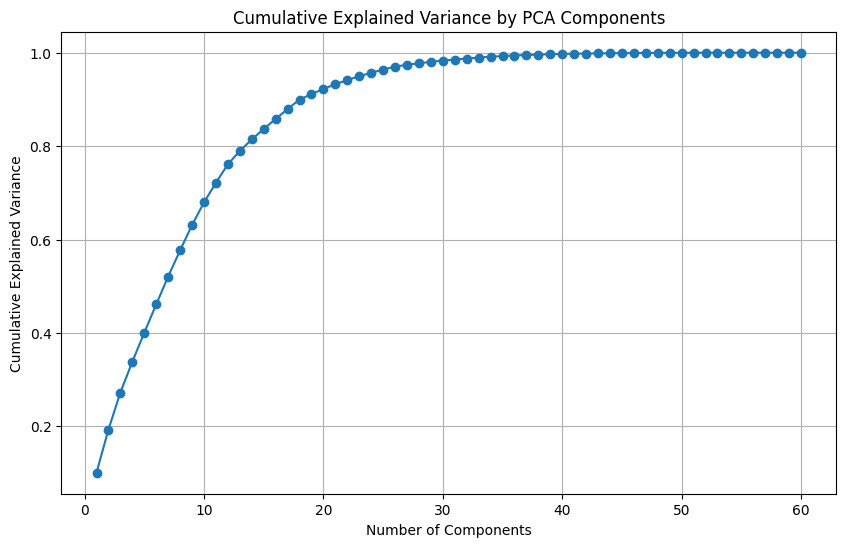

Selected 24 components to retain at least 95% of the variance.
K-means Davies-Bouldin Index: 0.69
Hierarchical Davies-Bouldin Index: 0.75
DBSCAN did not find any clusters (only noise).
GMM Davies-Bouldin Index: 0.82
 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 1.4727291209470494


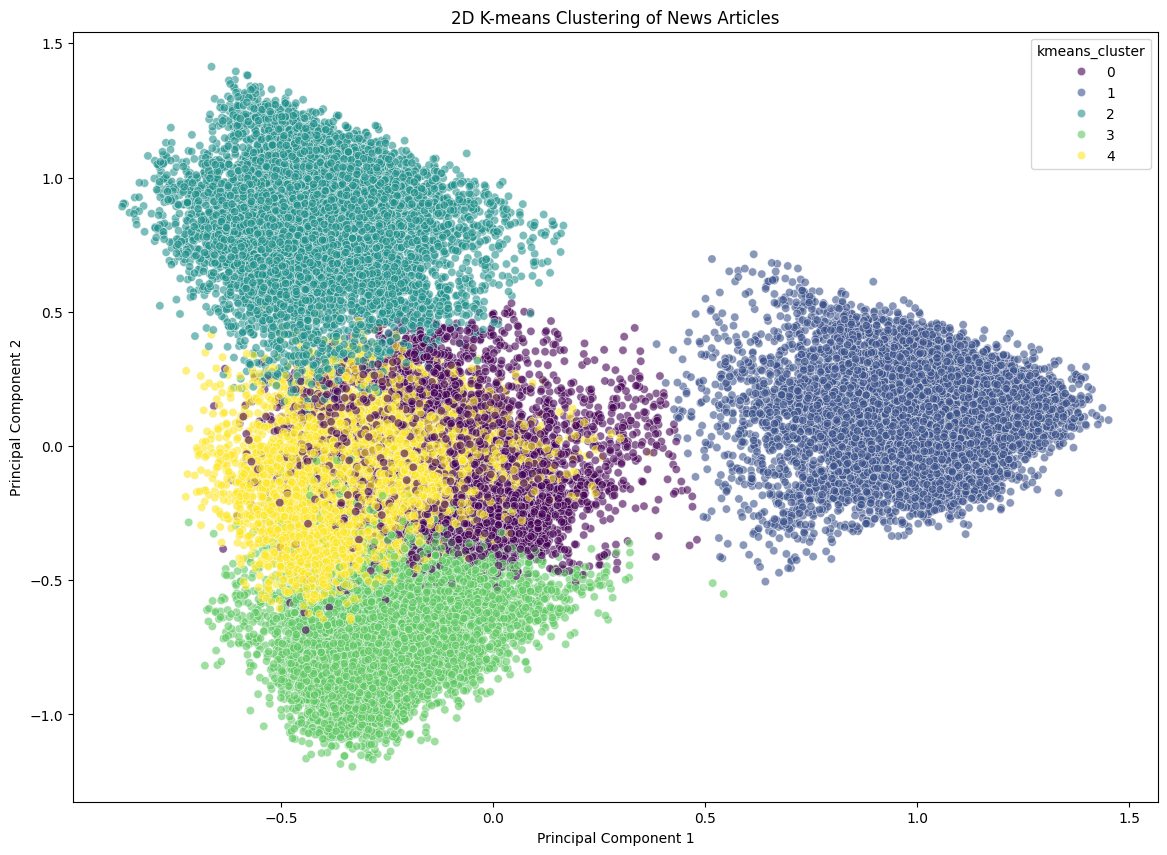

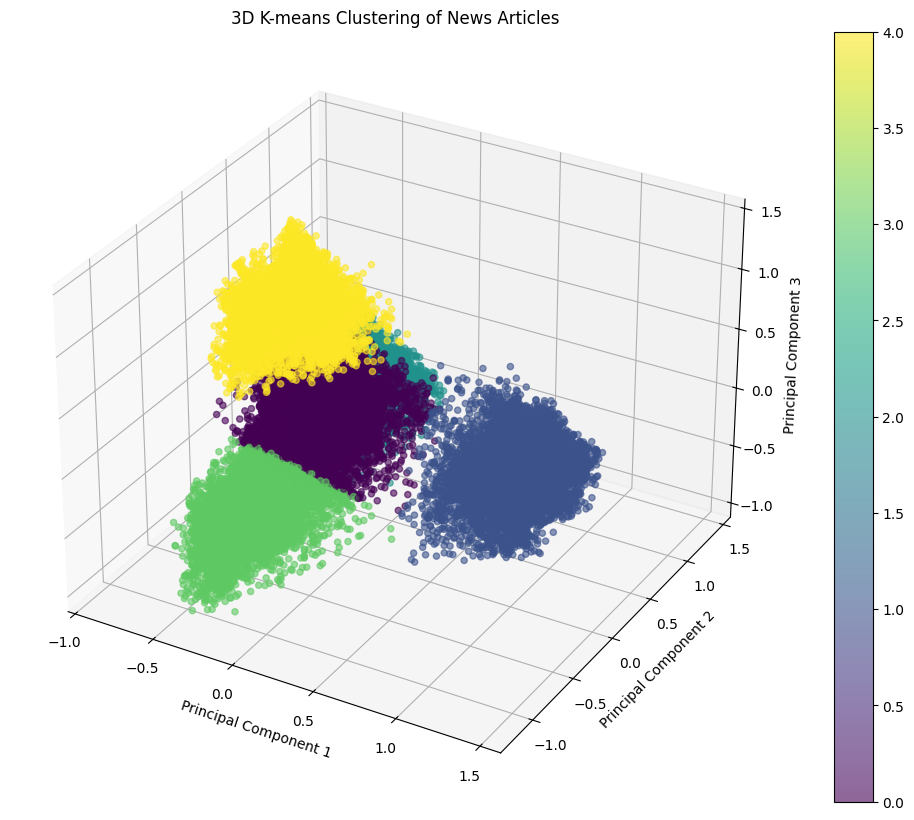

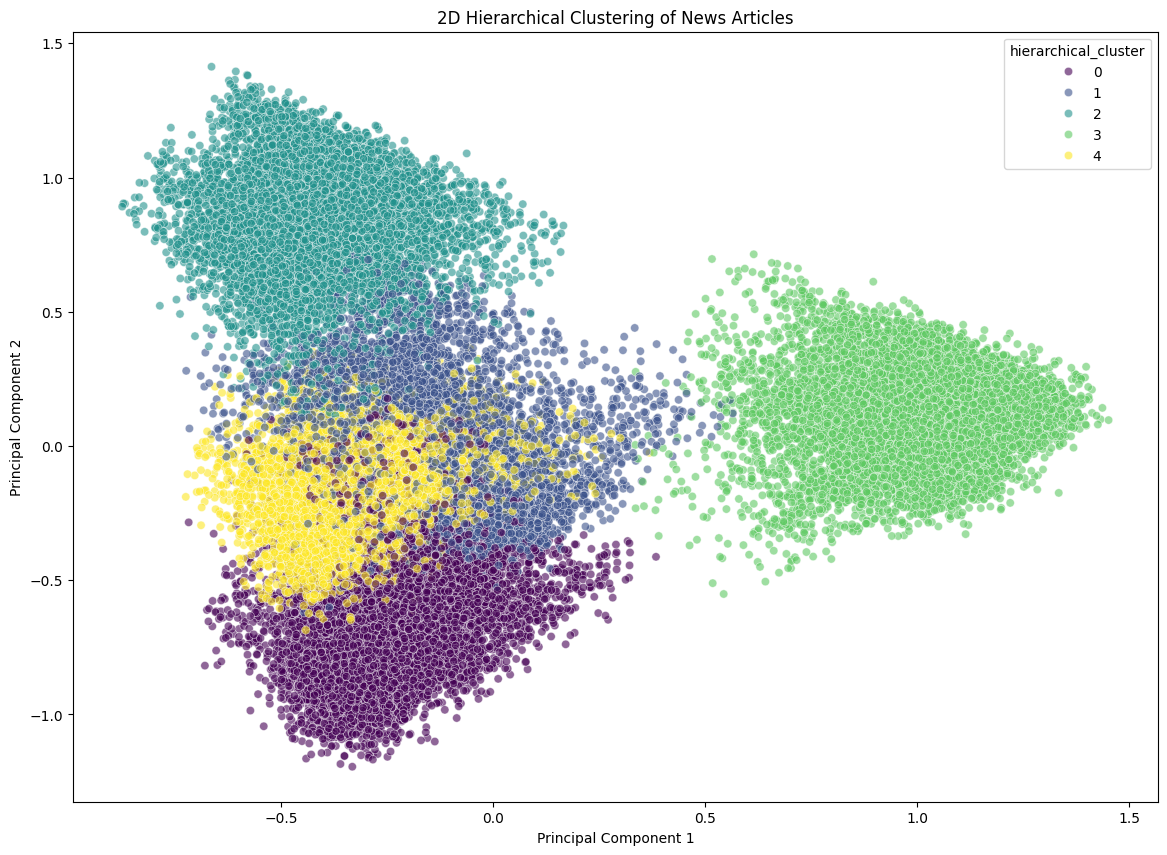

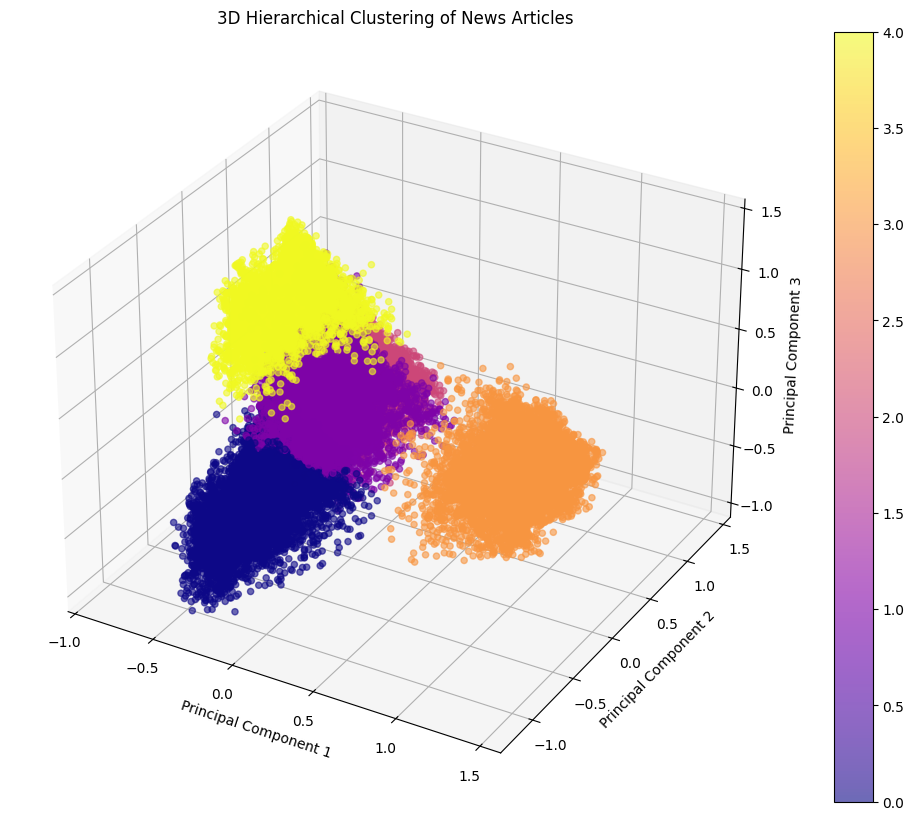

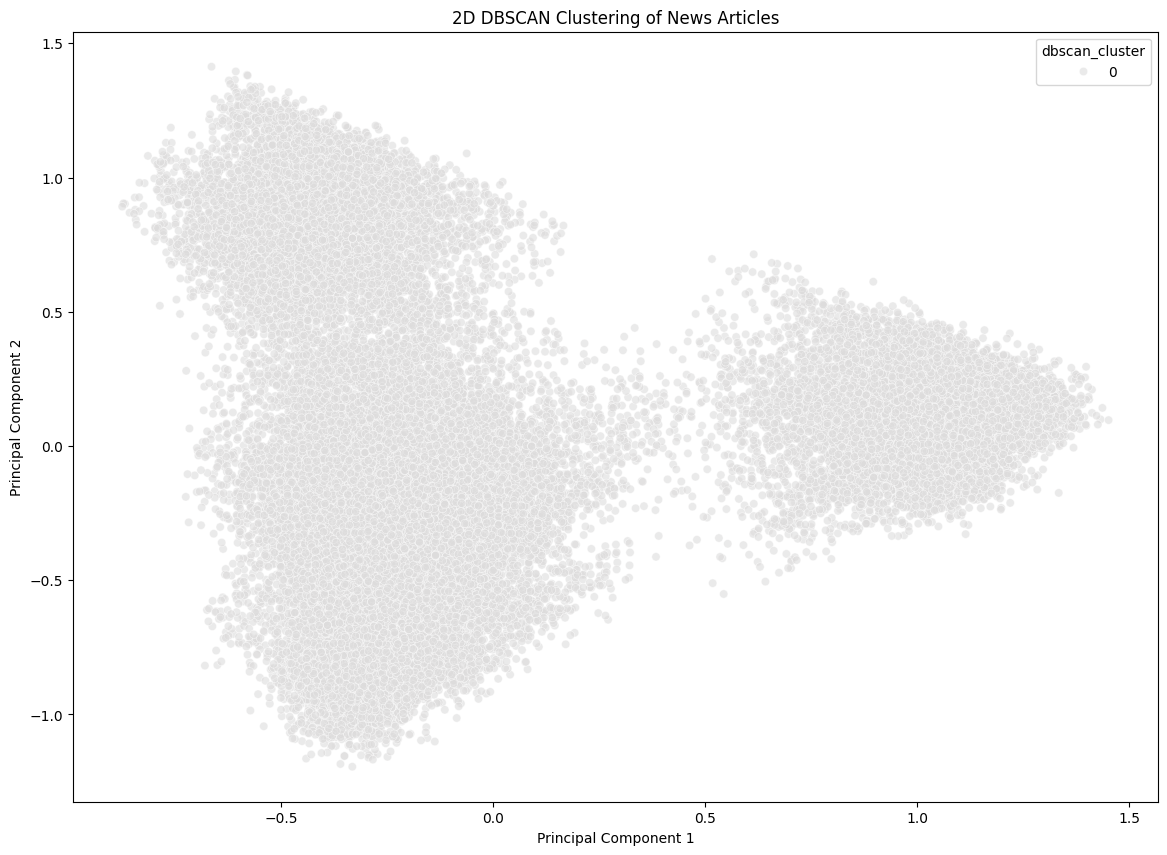

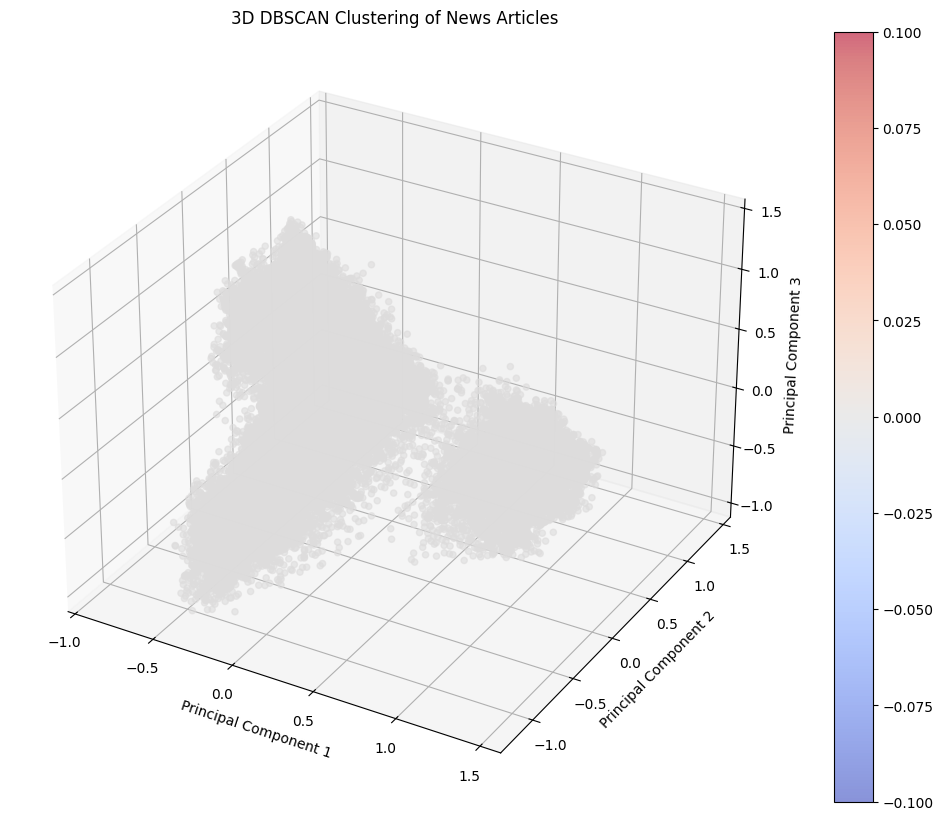

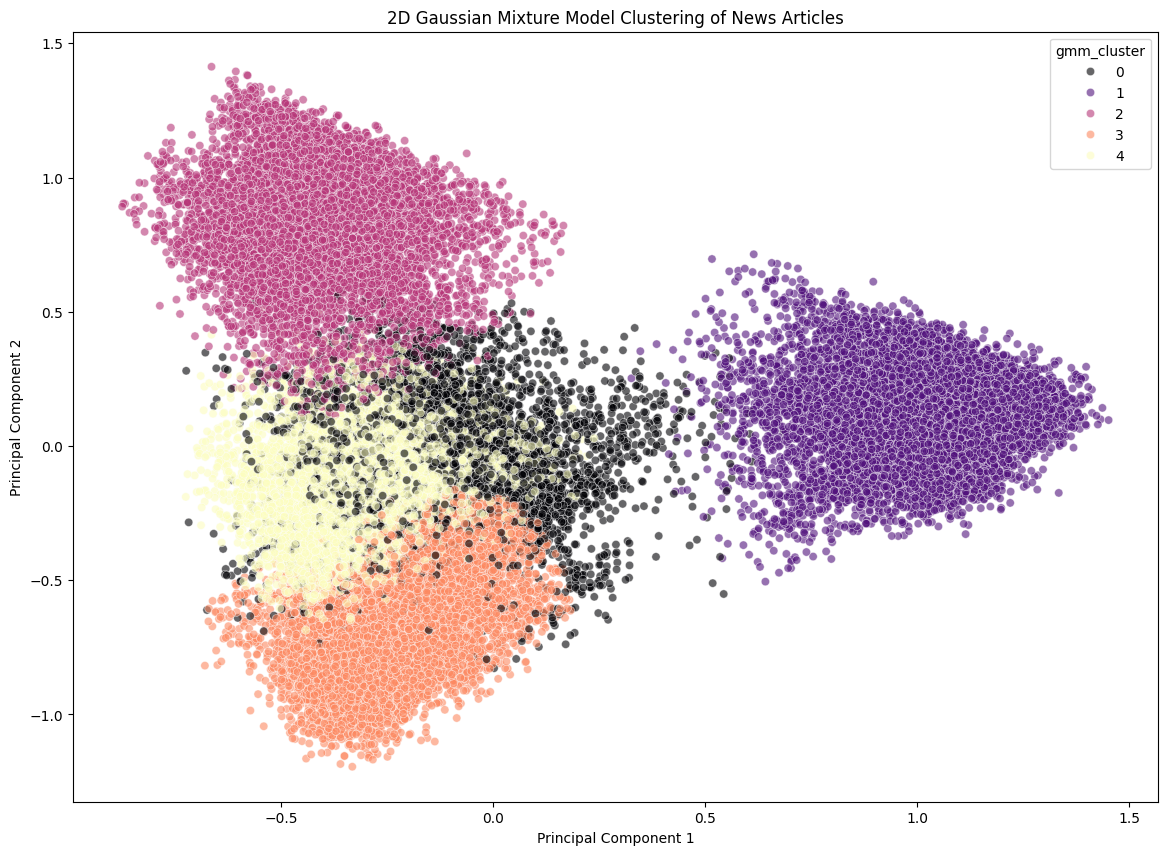

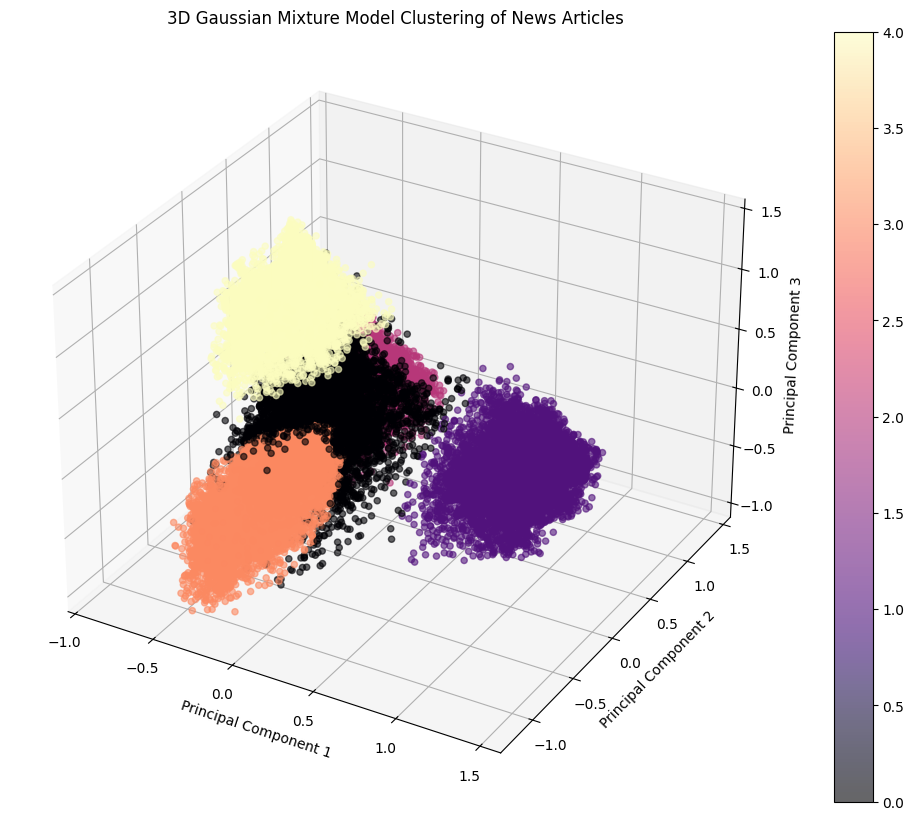

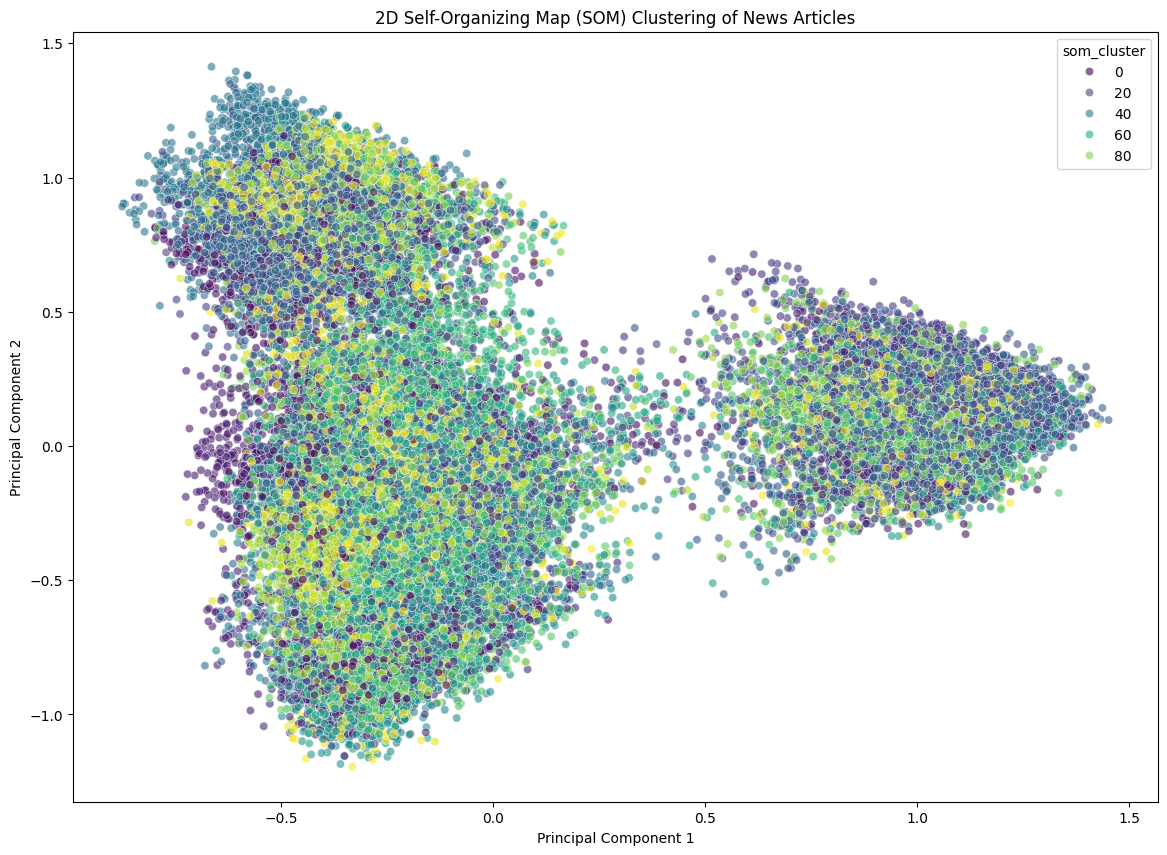

<function matplotlib.pyplot.show(close=None, block=None)>

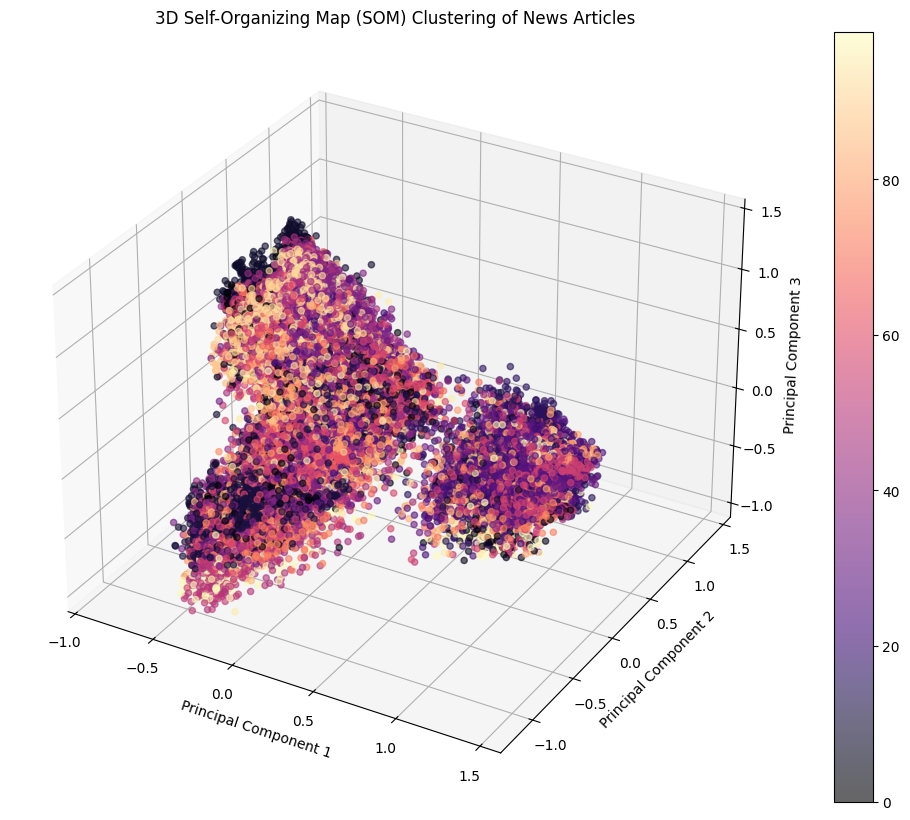

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler  # Use MinMaxScaler for normalization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from minisom import MiniSom  # Import SOM
# from fcmeans import FCM  # Import Fuzzy-C-Means
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset
df = pd.read_csv(os.path.join('..', '..', 'data', 'Social-media', 'OnlineNewsPopularity.csv'))

# Preprocessing: Handle missing values
df = df.dropna()

# Select relevant numerical columns for clustering
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Step 2: Normalize the features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[numeric_cols])

# Step 3: Dimensionality Reduction (show cumulative variance before selecting components)
pca = PCA()
pca_fit = pca.fit(df_normalized)
explained_variance = np.cumsum(pca_fit.explained_variance_ratio_)

# Plot cumulative variance explained by PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select enough components to retain at least 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1  # Add 1 because of 0-based indexing
pca = PCA(n_components=n_components)
pca_fit = pca.fit(df_normalized)
reduced_data = pca.transform(df_normalized)

print(f'Selected {n_components} components to retain at least 95% of the variance.')

# **Algorithm 1: K-means Clustering**
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(reduced_data[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate K-means clustering using Davies-Bouldin Index
kmeans_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['kmeans_cluster'])
print(f'K-means Davies-Bouldin Index: {kmeans_davies_bouldin:.2f}')

# **Algorithm 2: Hierarchical Clustering**
hierarchical = AgglomerativeClustering(n_clusters=5)
df['hierarchical_cluster'] = hierarchical.fit_predict(reduced_data[:, :3])

# Evaluate Hierarchical clustering using Davies-Bouldin Index
hierarchical_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['hierarchical_cluster'])
print(f'Hierarchical Davies-Bouldin Index: {hierarchical_davies_bouldin:.2f}')

# **Algorithm 3: Fuzzy-C-Means**
# fcm = FCM(n_clusters=5)
# fcm.fit(reduced_data)
# df['fcm_cluster'] = fcm.predict(reduced_data)

# # Evaluate Fuzzy-C-Means clustering using Davies-Bouldin Index
# fcm_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['fcm_cluster'])
# print(f'Fuzzy-C-Means Davies-Bouldin Index: {fcm_davies_bouldin:.2f}')

# **Algorithm 4: DBSCAN Clustering**
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(reduced_data[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate DBSCAN clustering using Davies-Bouldin Index (only if clusters are found)
if len(set(df['dbscan_cluster'])) > 1:
    dbscan_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['dbscan_cluster'])
    print(f'DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin:.2f}')
else:
    print('DBSCAN did not find any clusters (only noise).')

# **Algorithm 5: Gaussian Mixture Model (GMM)**
gmm = GaussianMixture(n_components=5, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(reduced_data[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate GMM clustering using Davies-Bouldin Index
gmm_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['gmm_cluster'])
print(f'GMM Davies-Bouldin Index: {gmm_davies_bouldin:.2f}')

# **Algorithm 6: Self-Organizing Map (SOM)**
som = MiniSom(x=10, y=10, input_len=reduced_data.shape[1], sigma=1.0, learning_rate=0.5)
som.train(reduced_data, 100, verbose=True)

# Get the winning neuron for each data point
winning_positions = np.array([som.winner(data) for data in reduced_data])
df['som_cluster'] = [pos[0] * 10 + pos[1] for pos in winning_positions]

# Plot 2D and 3D for each clustering method

# 2D K-means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['kmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D K-means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D Hierarchical plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['hierarchical_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Hierarchical plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['hierarchical_cluster'], cmap='plasma', alpha=0.6)
plt.title('3D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# # 2D Fuzzy-C-Means plot
# plt.figure(figsize=(14, 10))
# sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['fcm_cluster'], palette='cool', alpha=0.6)
# plt.title('2D Fuzzy-C-Means Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # 3D Fuzzy-C-Means plot
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['fcm_cluster'], cmap='cool', alpha=0.6)
# plt.title('3D Fuzzy-C-Means Clustering of News Articles')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.colorbar(sc)
# plt.show()

# 2D DBSCAN plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['dbscan_cluster'], palette='coolwarm', alpha=0.6)
plt.title('2D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D DBSCAN plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['dbscan_cluster'], cmap='coolwarm', alpha=0.6)
plt.title('3D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D GMM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['gmm_cluster'], palette='magma', alpha=0.6)
plt.title('2D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D GMM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['gmm_cluster'], cmap='magma', alpha=0.6)
plt.title('3D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D SOM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['som_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Self-Organizing Map (SOM) Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D SOM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['som_cluster'], cmap='magma', alpha=0.6)
plt.title('3D Self-Organizing Map (SOM) Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show
